<a href="https://colab.research.google.com/github/MarianoChic09/MSc-AI-taller-de-deep-learning/blob/main/MSc_AI_ORT_Taller_IA_Tarea1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller de Deep Learning - Tarea 1

Introducción:
El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

Dataset:
El dataset a ser utilizado consiste de más de 13.000 imágenes de entrenamiento agrupadas
en 6 posibles “escenarios”: edificios, bosques, glaciares, montañas, océanos, calles.
Pueden descargarlo en el siguiente link.
El mismo contiene dos carpetas (train_set y test_set) donde las imágenes están
agrupadas en sub carpetas de acuerdo a su categoría.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cp -r "/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification" .
! unzip -q scene_classification.zip
! rm scene_classification.zip

In [3]:
#%cd "/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification"
#%ls

## Cargando el dataset

In [4]:
import os

# os.chdir("/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification")

In [5]:
print(os.getcwd())

/content


In [6]:
print(os.listdir())
# os.chdir("./data/imgs")
print(os.listdir())
os.chdir("../../")
print(os.listdir())
os.chdir("/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification")
print(os.listdir())


['.config', 'drive', 'scene_classification', 'sample_data']
['.config', 'drive', 'scene_classification', 'sample_data']
['libx32', 'mnt', 'etc', 'home', 'root', 'lib', 'srv', 'sys', 'tmp', 'boot', 'lib64', 'run', 'proc', 'usr', 'bin', 'dev', 'lib32', 'var', 'opt', 'media', 'sbin', 'content', '.dockerenv', 'datalab', 'tools', 'python-apt', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']
['train_set', 'test_set', 'scene_classification', 'runs']


In [7]:
import os

print("Directorio actual:", os.getcwd())
# print("\nContenido de 'train_set':", os.listdir("train_set"))

Directorio actual: /content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification


In [8]:
# Reemplaza 'class_1' con el nombre de uno de tus subdirectorios.
print("Contenido de 'train_set/buildings':", os.listdir("train_set/buildings"))

Contenido de 'train_set/buildings': ['19513.jpg', '19447.jpg', '19456.jpg', '1959.jpg', '19460.jpg', '1954.jpg', '19584.jpg', '1964.jpg', '19638.jpg', '19608.jpg', '19455.jpg', '19526.jpg', '19416.jpg', '19556.jpg', '19623.jpg', '19446.jpg', '19407.jpg', '1943.jpg', '19466.jpg', '2059.jpg', '2099.jpg', '1979.jpg', '2170.jpg', '19901.jpg', '19778.jpg', '19969.jpg', '19830.jpg', '19923.jpg', '20048.jpg', '19913.jpg', '2083.jpg', '19895.jpg', '19649.jpg', '19848.jpg', '2076.jpg', '19976.jpg', '2136.jpg', '19728.jpg', '19806.jpg', '19963.jpg', '19996.jpg', '19855.jpg', '20027.jpg', '1977.jpg', '20054.jpg', '20011.jpg', '19713.jpg', '2144.jpg', '19802.jpg', '2002.jpg', '19915.jpg', '19701.jpg', '19896.jpg', '2038.jpg', '19674.jpg', '19689.jpg', '2108.jpg', '19973.jpg', '19661.jpg', '2171.jpg', '19776.jpg', '19846.jpg', '19910.jpg', '2158.jpg', '19816.jpg', '19874.jpg', '19789.jpg', '20017.jpg', '2114.jpg', '2088.jpg', '19666.jpg', '19722.jpg', '2069.jpg', '19800.jpg', '19735.jpg', '19978.jp

In [9]:
all_extensions = set()  # Para almacenar todas las extensiones encontradas

# Iterar sobre cada subdirectorio en "train_set"
for folder in os.listdir("train_set"):
    # Determinar las extensiones de archivos en el subdirectorio actual
    extensions = {os.path.splitext(file)[1].lower() for file in os.listdir(f"train_set/{folder}")}
    all_extensions.update(extensions)

    print(f"Para la carpeta {folder}:")
    print(extensions)
    print("-" * 50)

print("Todas las extensiones encontradas:", all_extensions)

Para la carpeta street:
{'.jpg'}
--------------------------------------------------
Para la carpeta forest:
{'.jpg'}
--------------------------------------------------
Para la carpeta mountain:
{'.jpg'}
--------------------------------------------------
Para la carpeta buildings:
{'.jpg'}
--------------------------------------------------
Para la carpeta glacier:
{'.jpg'}
--------------------------------------------------
Para la carpeta sea:
{'.jpg'}
--------------------------------------------------
Todas las extensiones encontradas: {'.jpg'}


In [10]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import torch

class CustomCNN(nn.Module):
  def __init__(self, in_channels,number_classes):
    # in_channels: int, cantidad de canales de la imagen original
    super(CustomCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels = 32, kernel_size = 3,padding=1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3,padding=1)
    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3,padding=1)
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3,padding=1)
    self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 120, kernel_size = 3,padding=1)

    self.linear1 = nn.Linear(in_features = 120*18*18, out_features = 512)
    self.linear2 = nn.Linear(in_features = 512, out_features = number_classes)

    self.max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = self.max_pooling(out)

    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    out = self.max_pooling(out)

    out = F.relu(self.conv5(out))
    out = self.max_pooling(out)

    out = self.dropout(out).flatten(1)

    out = F.relu(self.linear1(out))
    out = self.dropout(out)
    out = self.linear2(out)
    return out

In [11]:
# def get_dataloaders(train_dataset, test_dataset, batch_size):

#     train_size = int(0.8 * len(train_dataset))
#     valid_size = len(train_dataset) - train_size
#     train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

#     return train_loader, valid_loader, test_loader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/experimento_1')

def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in loader:
      all_labels.extend(labels.numpy())

      optim.zero_grad()

      predictions = training_model(images.to(device))
      all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

      loss = criterion(predictions, labels.to(device))

      loss.backward()
      optim.step()

      epoch_loss += loss.item()

      precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
      recall = recall_score(all_labels, all_predictions, average='macro', zero_division=1)
      f1 = f1_score(all_labels, all_predictions, average='macro')

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision, recall, f1


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
      for images, labels in loader:
        all_labels.extend(labels.numpy())

        predictions = val_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        loss = criterion(predictions, labels.to(device))

        epoch_loss += loss.item()
        precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='macro', zero_division=1)
        f1 = f1_score(all_labels, all_predictions, average='macro')

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision, recall, f1


def train_model(model, train_loader, test_loader, criterion, optim, number_epochs,experiment_name='experimento_1'):
  train_history = []
  test_history = []
  accuracy_history = []
  writer = SummaryWriter(f'runs/{experiment_name}')  # Inicializar el escritor de TensorBoard


  for epoch in range(number_epochs):
      start_time = time.time()

      train_loss, train_acc, train_precision, train_recall, train_f1 = train_epoch(model, train_loader, criterion, optimizer)
      # Registrar métricas de entrenamiento en TensorBoard
      writer.add_scalar('Training Loss', train_loss, epoch)
      writer.add_scalar('Training Accuracy', train_acc, epoch)
      writer.add_scalar('Training Precision', train_precision, epoch)
      writer.add_scalar('Training Recall', train_recall, epoch)
      writer.add_scalar('Training F1', train_f1, epoch)

      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | F1 Score {:.2f}% | Time {:.2f} seconds"
              .format(epoch + 1, train_loss, train_acc, train_precision*100, train_recall*100, train_f1*100, time.time() - start_time))
      # print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
      #       .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

      start_time = time.time()
      test_loss, acc, val_precision, val_recall, val_f1 = validation_epoch(model, test_loader, criterion)

      # Registrar métricas de validación en TensorBoard
      writer.add_scalar('Validation Loss', test_loss, epoch)
      writer.add_scalar('Validation Accuracy', acc, epoch)
      writer.add_scalar('Validation Precision', val_precision, epoch)
      writer.add_scalar('Validation Recall', val_recall, epoch)
      writer.add_scalar('Validation F1', val_f1, epoch)

      test_history.append(test_loss)
      accuracy_history.append(acc)
      # print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
      #       .format(epoch + 1, test_loss, acc, time.time() - start_time))
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | F1 Score {:.2f}% | Time {:.2f} seconds"
              .format(epoch + 1, test_loss, acc, val_precision*100, val_recall*100, val_f1*100, time.time() - start_time))

def test_model(test_model, loader, criterion):
    test_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            all_labels.extend(labels.numpy())

            predictions = test_model(images.to(device))
            all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

            loss = criterion(predictions, labels.to(device))
            epoch_loss += loss.item()

            precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
            recall = recall_score(all_labels, all_predictions, average='macro', zero_division=1)
            f1 = f1_score(all_labels, all_predictions, average='macro')

        print("Test | Loss {:.6f} | Accuracy {:.2f}% | Precision {:.2f}% | Recall {:.2f}% | F1 Score {:.2f}%"
      .format(epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision*100, recall*100, f1*100))


    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision, recall, f1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [12]:
import os

dataset_dir = './train_set'

class_distribution = {}

for class_dir in os.listdir(dataset_dir):
    class_dir_path = os.path.join(dataset_dir, class_dir)

    if os.path.isdir(class_dir_path):
        img_count = len([f for f in os.listdir(class_dir_path) if os.path.isfile(os.path.join(class_dir_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_distribution[class_dir] = img_count

for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")

street: 2382
forest: 2271
mountain: 2512
buildings: 2191
glacier: 2404
sea: 2274


# Augmentations

Entreno el Custom CNN con un "baseline" sin transformaciones y despues otro agregando algunas de estas transformaciones para comparar y ver si mejora el accuracy.

## Baseline

In [13]:
print(os.listdir())
# os.chdir("./data/imgs")
print(os.listdir())
os.chdir("../../")
print(os.listdir())
os.chdir("/content/drive/MyDrive/Colab Notebooks/Datasets/scene_classification")
print(os.listdir())

['train_set', 'test_set', 'scene_classification', 'runs']
['train_set', 'test_set', 'scene_classification', 'runs']
['Untitled0.ipynb', 'Copia de Desafio_Final 31-03.ipynb', 'Data', 'Notebook', 'Untitled1.ipynb', 'data_final_modelado.csv', 'Desafio_Final - Colab.ipynb', 'Desafio_Final - Entregable.ipynb', 'Desafio_Final - Colab Pipeline.ipynb', 'Compartir Bruno Lucas - Halley', 'Copy of Whisper2.ipynb', 'Correlacion-Flotacion-Mineralogia.ipynb', 'Untitled2.ipynb', 'Forecast-Velocidad-de-Espuma-Flotacion.ipynb', 'Analisis Camaras IDAS TPH.ipynb', 'main 2.ipynb', 'Temporal_Difference.ipynb', 'Intro_to_Pytorch.ipynb', 'Untitled3.ipynb', 'Prueba de algoritmos DQN y DDQN.ipynb', 'Untitled (1)', 'practico_stable_baselines.ipynb', 'Colab - Obligatorio_2023_Letra.ipynb', 'Obligatorio Final', 'Videos-Mario-Agentes-Inteligentes-2023.ipynb', 'Obligatorio_2023_Letra (1).ipynb', 'Untitled4.ipynb', 'Parcial 12 12 2022 de Analisis Predictivo de Series Temporales.ipynb', 'Parcial 14-12-2022 de Analisi

In [14]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Me aseguro que las imagenes tienen el mismo tamaño
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

BATCH_SIZE = 10

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


BATCH_SIZE = 10
LR = 0.001
NUMBER_EPOCHS = 5
criterion = nn.CrossEntropyLoss().to(device)

# defino la red baseline y su optimizador
modelo_sin_aug = CustomCNN(3, 6).to(device)
optimizer = torch.optim.Adam(modelo_sin_aug.parameters(), lr=LR)

# Entreno el modelo
train_model(modelo_sin_aug, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.052647 | Accuracy 57.09% | Precision 56.13% | Recall 56.90% | F1 Score 56.14% | Time 54.25 seconds
Validation epoch 1 | Loss 0.943610 | Accuracy 64.27% | Precision 65.14% | Recall 65.03% | F1 Score 63.48% | Time 7.41 seconds
Training epoch 2 | Loss 0.779591 | Accuracy 70.34% | Precision 70.43% | Recall 70.41% | F1 Score 70.40% | Time 53.33 seconds
Validation epoch 2 | Loss 0.647831 | Accuracy 75.31% | Precision 76.03% | Recall 75.33% | F1 Score 75.14% | Time 7.42 seconds
Training epoch 3 | Loss 0.665322 | Accuracy 75.36% | Precision 75.49% | Recall 75.50% | F1 Score 75.48% | Time 52.51 seconds
Validation epoch 3 | Loss 0.608174 | Accuracy 76.88% | Precision 77.11% | Recall 76.82% | F1 Score 76.75% | Time 7.23 seconds
Training epoch 4 | Loss 0.569170 | Accuracy 78.78% | Precision 78.96% | Recall 78.94% | F1 Score 78.95% | Time 52.78 seconds
Validation epoch 4 | Loss 0.567593 | Accuracy 79.87% | Precision 80.6

In [15]:
test_loss, test_accuracy,  test_precision, test_recall, test_f1 = test_model(modelo_sin_aug, test_loader, criterion)
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("Test Precision: {:.6f}".format(test_precision))
print("Test Recall: {:.2f}%".format(test_recall))
print("Test F1: {:.6f}".format(test_f1))

Test | Loss 0.544546 | Accuracy 79.93% | Precision 80.67% | Recall 80.20% | F1 Score 80.19%
Test Loss: 0.544546
Test Accuracy: 79.93%
Test Precision: 0.806724
Test Recall: 0.80%
Test F1: 0.801865


## Modelo con Augmentations

In [16]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# train_transform  = transforms.Compose([
#     #transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
#     # transforms.RandomRotation(15),
#     # transforms.RandomHorizontalFlip(),
#     transforms.Resize((150, 150)),
#     transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.25, 1.25), shear=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
# ])

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomAffine(degrees=0.4*180/np.pi,
                            translate=(0.5, 0.3),
                            scale=(1-0.4, 1+0.4),
                            shear=0.3*180/np.pi),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.ColorJitter(brightness=(0.1, 0.6)),
    transforms.RandomRotation(degrees=0.4*180/np.pi),
    transforms.ToTensor()  # This converts the image to the [0,1] range
])


test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

BATCH_SIZE = 10

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 40
LR = 0.01
NUMBER_EPOCHS = 15
criterion = nn.CrossEntropyLoss().to(device)

modelo_con_aug = CustomCNN(3, 6).to(device)
optimizer = torch.optim.Adam(modelo_con_aug.parameters(), lr=LR)

train_model(modelo_con_aug, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)


11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.888597 | Accuracy 17.24% | Precision 17.33% | Recall 16.45% | F1 Score 13.02% | Time 61.18 seconds
Validation epoch 1 | Loss 1.791100 | Accuracy 17.39% | Precision 2.90% | Recall 16.67% | F1 Score 4.94% | Time 9.46 seconds
Training epoch 2 | Loss 1.792657 | Accuracy 17.75% | Precision 13.11% | Recall 16.64% | F1 Score 10.63% | Time 59.87 seconds
Validation epoch 2 | Loss 1.794661 | Accuracy 16.85% | Precision 2.81% | Recall 16.67% | F1 Score 4.81% | Time 9.47 seconds
Training epoch 3 | Loss 1.792193 | Accuracy 17.52% | Precision 16.70% | Recall 16.68% | F1 Score 13.06% | Time 59.40 seconds
Validation epoch 3 | Loss 1.791845 | Accuracy 16.74% | Precision 2.79% | Recall 16.67% | F1 Score 4.78% | Time 9.46 seconds
Training epoch 4 | Loss 1.792683 | Accuracy 17.09% | Precision 15.49% | Recall 16.23% | F1 Score 12.19% | Time 59.18 seconds
Validation epoch 4 | Loss 1.790889 | Accuracy 16.85% | Precision 2.81% | Re

--------

In [17]:
test_loss, test_accuracy,  test_precision, test_recall, test_f1 = test_model(modelo_con_aug, test_loader, criterion)
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("Test Precision: {:.6f}".format(test_precision))
print("Test Recall: {:.2f}%".format(test_recall))
print("Test F1: {:.6f}".format(test_f1))

Test | Loss 1.790672 | Accuracy 17.50% | Precision 2.92% | Recall 16.67% | F1 Score 4.96%
Test Loss: 1.790672
Test Accuracy: 17.50%
Test Precision: 0.029167
Test Recall: 0.17%
Test F1: 0.049645


# Dense Net

In [65]:
import math
def compute_same_padding(input_shape, strides, kernel_size):
    padding_total = (input_shape*strides-input_shape-strides+kernel_size)/2
    return math.ceil(padding_total/2)

In [66]:
class CompositeFunction(nn.Module):
    #BatchNorm + Relu + Conv
    def __init__(self, in_channels, out_channels, kernel_size, input_shape, strides = 1):
        super(CompositeFunction, self).__init__()
        self.bn = nn.BatchNorm2d(num_features = in_channels)
        P = compute_same_padding(input_shape, strides, kernel_size)
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = P)

    def forward(self, x):
        out = self.bn(x)
        out = self.conv(F.relu(out))
        return out

In [67]:
class DenseBlock(nn.Module):
  #out_channels = in_channels + k * reps
  #bottleneck = 4*k
  def __init__(self, in_channels, reps, k, input_shape):
    super(DenseBlock, self).__init__()
    # Su implementacion
    self.reps = reps
    self.convs = []
    for i in range(reps):
        self.convs.append(CompositeFunction(in_channels+k*i, 4*k, 1, input_shape))
        self.convs.append(CompositeFunction(4*k, k, 3, input_shape))

    self.convs = nn.ModuleList(self.convs)

  def forward(self, x):
    for i in range(self.reps):
        x1 = self.convs[2*i](x)
        x2 = self.convs[2*i+1](x1)
        x = torch.cat([x,x2],1)
    return x

In [68]:
class TransitionLayer(nn.Module):
  def __init__(self, in_channels, out_channels, input_shape):
    super(TransitionLayer, self).__init__()
    self.comp = CompositeFunction(in_channels, out_channels, 1, input_shape)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    out = self.comp(x)
    out = self.pool(out)
    return out

In [77]:
class DenseNet(nn.Module):
    #DenseNet 121
    def __init__(self, n_classes, input_shape, k):
        super(DenseNet, self).__init__()
        self.input_conv = CompositeFunction(in_channels = 3, out_channels = 2*k ,kernel_size = 7, input_shape = input_shape, strides = 2)
        self.input_max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.dense_block1 = DenseBlock(2*k, 6, k, int(input_shape/2))
        self.transitionLayer1 = TransitionLayer(in_channels=(6+2)*k, out_channels=4*k,  input_shape = int(input_shape/2))

        self.dense_block2 = DenseBlock(4*k, 12, k, int(input_shape/4))
        self.transitionLayer2 = TransitionLayer(in_channels=(12+4)*k, out_channels=8*k, input_shape =int(input_shape/4))

        self.dense_block3 = DenseBlock(8*k, 24, k, int(input_shape/8))
        self.transitionLayer3 = TransitionLayer(in_channels=(24+8)*k, out_channels=16*k, input_shape =int(input_shape/8))

        self.dense_block4 = DenseBlock(16*k, 16, k, input_shape =int(input_shape/16))
        last_number_of_filters = 16*k+16*k
        # Classifier
        # h = int(input_shape/16)
        # w = h
        h = int(input_shape / (2**4))  # As per your code
        w = h
        num_features_before_fc1 = last_number_of_filters * w * h
        self.fully_connected_1 = nn.Linear(12800, 512)#num_features_before_fc1, 512)
        self.output = nn.Linear(512, n_classes)


    def forward(self, x):
        out = self.input_conv(x)
        out = self.input_max_pooling(out)
        out = self.dense_block1(out)
        out = self.transitionLayer1(out)
        out = self.dense_block2(out)
        out = self.transitionLayer2(out)
        out = self.dense_block3(out)
        out = self.transitionLayer3(out)
        out = self.dense_block4(out)
        out = out.flatten(1)
        out = F.relu(self.fully_connected_1(out))
        out = self.output(out)

        return out

In [78]:
densenet = DenseNet(10, 32, 4).to(device)
optimizer = torch.optim.Adam(densenet.parameters(), lr=LR)

In [79]:
BATCH_SIZE = 10
NUMBER_EPOCHS = 10

import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Me aseguro que las imagenes tienen el mismo tamaño
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


BATCH_SIZE = 10
LR = 0.001
NUMBER_EPOCHS = 10
criterion = nn.CrossEntropyLoss().to(device)

densenet = DenseNet(10, 32, 4).to(device)
optimizer = torch.optim.Adam(densenet.parameters(), lr=LR)
# train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

train_model(densenet, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.049164 | Accuracy 59.62% | Precision 51.00% | Recall 65.36% | F1 Score 50.98% | Time 112.09 seconds
Validation epoch 1 | Loss 0.937133 | Accuracy 64.23% | Precision 66.92% | Recall 64.60% | F1 Score 64.52% | Time 12.34 seconds
Training epoch 2 | Loss 0.823950 | Accuracy 68.38% | Precision 68.48% | Recall 68.49% | F1 Score 68.48% | Time 111.55 seconds
Validation epoch 2 | Loss 0.926339 | Accuracy 63.84% | Precision 64.90% | Recall 64.47% | F1 Score 63.23% | Time 12.03 seconds
Training epoch 3 | Loss 0.704869 | Accuracy 73.08% | Precision 73.28% | Recall 73.22% | F1 Score 73.24% | Time 110.10 seconds
Validation epoch 3 | Loss 0.662156 | Accuracy 75.88% | Precision 76.20% | Recall 75.90% | F1 Score 75.94% | Time 12.25 seconds
Training epoch 4 | Loss 0.606767 | Accuracy 77.59% | Precision 77.78% | Recall 77.77% | F1 Score 77.77% | Time 111.23 seconds
Validation epoch 4 | Loss 0.590581 | Accuracy 78.48% | Precisi

In [81]:
test_transform = transforms.Compose([
  transforms.ToTensor()
])

# _, _, test_loader = get_dataloaders(None, test_transform, BATCH_SIZE)

# test_loss, accuracy = validation_epoch(densenet, test_loader, criterion)

test_loss, test_accuracy,  test_precision, test_recall, test_f1 = test_model(densenet, test_loader, criterion)

print(f"DenseNet Test set:\n")
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("Test Precision: {:.6f}".format(test_precision))
print("Test Recall: {:.2f}%".format(test_recall))
print("Test F1: {:.6f}".format(test_f1))



Test | Loss 0.817400 | Accuracy 76.67% | Precision 77.44% | Recall 76.83% | F1 Score 76.57%
DenseNet Test set:

Test Loss: 0.817400
Test Accuracy: 76.67%
Test Precision: 0.774416
Test Recall: 0.77%
Test F1: 0.765699


In [83]:
!tensorboard --logdir=runs


2023-10-15 01:44:06.143310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)


# ResNet


### Deep Residual Learning for Image Recognition
Paper: https://arxiv.org/pdf/1512.03385.pdf

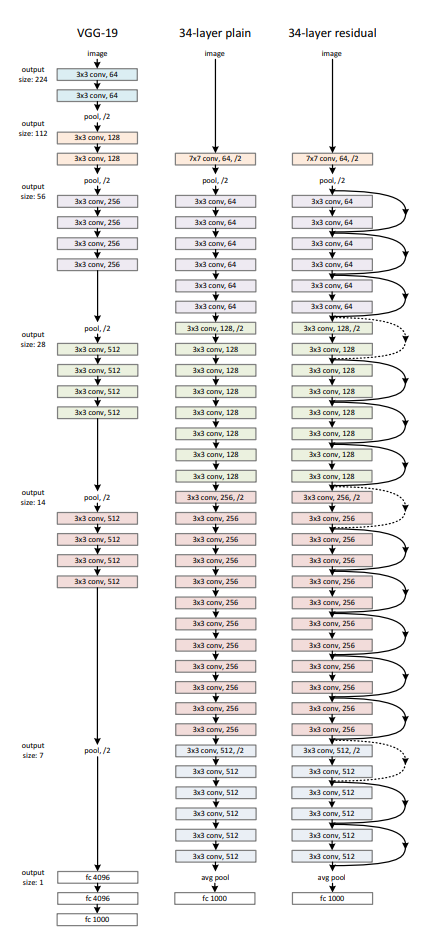

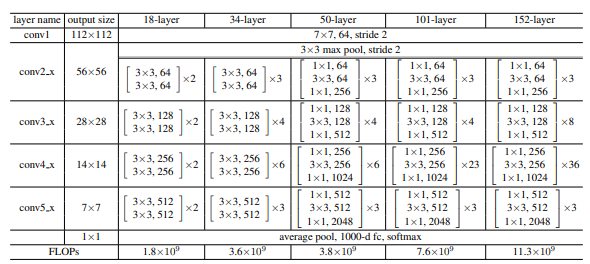

In [ ]:
# class Block(nn.module):


In [18]:
import torch
import torch.nn as nn
from torchsummary import summary

class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
      super(Bottleneck, self).__init__()
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU(inplace=True)
      self.downsample = downsample

  def forward(self, x):
      residual = x
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)
      out = self.conv3(out)
      out = self.bn3(out)

      if self.downsample:
          residual = self.downsample(x)

      out += residual
      out = self.relu(out)
      return out


class ResNet(nn.Module):
  def __init__(self, block, layers, num_classes=1000):
      super(ResNet, self).__init__()
      self.in_channels = 64
      self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
      self.bn1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.layer1 = self._make_layer(block, 64, layers[0])
      self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
      self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
      self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):
      downsample = None
      if stride != 1 or self.in_channels != out_channels * block.expansion:
          downsample = nn.Sequential(
              nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(out_channels * block.expansion)
          )
      layers = []
      layers.append(block(self.in_channels, out_channels, stride, downsample))
      self.in_channels = out_channels * block.expansion
      for i in range(1, blocks):
          layers.append(block(self.in_channels, out_channels))

      return nn.Sequential(*layers)

  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.fc(x)
      return x


def resnet50(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 6, 3], num_classes = num_classes)

def resnet101(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 23, 3], num_classes = num_classes)

def resnet152(num_classes=1000):
  return ResNet(Bottleneck, [3, 4, 36, 3], num_classes = num_classes)

model_resnet50 = resnet50(num_classes = 10).to(device)

summary(model_resnet50,input_size=(3,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]           4,096
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
           Conv2d-11          [-1, 256, 38, 38]          16,384
      BatchNorm2d-12          [-1, 256, 38, 38]             512
           Conv2d-13          [-1, 256, 38, 38]          16,384
      BatchNorm2d-14          [-1, 256,

In [19]:
# def get_dataloaders(train_dataset, test_dataset, batch_size):

#     train_size = int(0.8 * len(train_dataset))
#     valid_size = len(train_dataset) - train_size
#     train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4)

#     return train_loader, valid_loader, test_loader
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/')

# def train_epoch(training_model, loader, criterion, optim):
#     training_model.train()
#     epoch_loss = 0.0
#     all_labels = []
#     all_predictions = []

#     for images, labels in loader:
#       all_labels.extend(labels.numpy())

#       optim.zero_grad()

#       predictions = training_model(images.to(device))
#       all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

#       loss = criterion(predictions, labels.to(device))

#       loss.backward()
#       optim.step()

#       epoch_loss += loss.item()

#     return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


# def validation_epoch(val_model, loader, criterion):
#     val_model.eval()
#     epoch_loss = 0.0
#     all_labels = []
#     all_predictions = []

#     with torch.no_grad():
#       for images, labels in loader:
#         all_labels.extend(labels.numpy())

#         predictions = val_model(images.to(device))
#         all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

#         loss = criterion(predictions, labels.to(device))

#         epoch_loss += loss.item()

#     return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


# def train_model(model, train_loader, test_loader, criterion, optim, number_epochs, run_name):
#   writer = SummaryWriter(f'runs/{run_name}')
#   train_history = []
#   test_history = []
#   accuracy_history = []

#   for epoch in range(number_epochs):
#       start_time = time.time()

#       train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
#       train_history.append(train_loss)
#       print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
#             .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

#       start_time = time.time()
#       test_loss, acc = validation_epoch(model, test_loader, criterion)
#       test_history.append(test_loss)
#       accuracy_history.append(acc)
#       print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
#             .format(epoch + 1, test_loss, acc, time.time() - start_time))

#       writer.add_scalar('Training loss', train_loss, epoch)
#       writer.add_scalar('Training accuracy', train_acc, epoch)
#       writer.add_scalar('Validation loss', test_loss, epoch)
#       writer.add_scalar('Validation accuracy', acc, epoch)
#       for name, param in model.named_parameters():
#             writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
#             if param.grad is not None:
#                 writer.add_histogram(f"{name}.grad", param.grad.clone().cpu().data.numpy(), epoch)

#       writer.close()

# def test_model(test_model, loader, criterion):
#     test_model.eval()
#     epoch_loss = 0.0
#     all_labels = []
#     all_predictions = []

#     with torch.no_grad():
#         for images, labels in loader:
#             all_labels.extend(labels.numpy())

#             predictions = test_model(images.to(device))
#             all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

#             loss = criterion(predictions, labels.to(device))
#             epoch_loss += loss.item()

#     return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device)

In [20]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from datetime import datetime


torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

#
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


BATCH_SIZE = 20
LR = 0.0001
NUMBER_EPOCHS = 20
criterion = nn.CrossEntropyLoss().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet50 = resnet50(num_classes = 10).to(device)

# summary(model_resnet50,input_size=(3,150,150))

optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=LR)

run_name = 'resnet_sin_aug'+str(datetime.now())

train_model(model_resnet50, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS,run_name)


11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.066600 | Accuracy 58.87% | Precision 50.23% | Recall 64.68% | F1 Score 50.26% | Time 44.72 seconds
Validation epoch 1 | Loss 1.038655 | Accuracy 61.99% | Precision 65.30% | Recall 61.33% | F1 Score 61.77% | Time 6.47 seconds
Training epoch 2 | Loss 0.728775 | Accuracy 72.62% | Precision 72.59% | Recall 72.67% | F1 Score 72.63% | Time 44.16 seconds
Validation epoch 2 | Loss 0.868667 | Accuracy 67.12% | Precision 73.69% | Recall 67.73% | F1 Score 67.34% | Time 6.76 seconds
Training epoch 3 | Loss 0.576529 | Accuracy 79.29% | Precision 79.37% | Recall 79.41% | F1 Score 79.39% | Time 44.35 seconds
Validation epoch 3 | Loss 0.658206 | Accuracy 76.13% | Precision 78.90% | Recall 76.07% | F1 Score 75.71% | Time 6.50 seconds
Training epoch 4 | Loss 0.482748 | Accuracy 82.32% | Precision 82.42% | Recall 82.44% | F1 Score 82.43% | Time 44.45 seconds
Validation epoch 4 | Loss 0.649347 | Accuracy 76.06% | Precision 78.1

In [22]:
# test_loss, test_accuracy = test_model(model_resnet50, test_loader, criterion)
# print("Test Loss: {:.6f}".format(test_loss))
# print("Test Accuracy: {:.2f}%".format(test_accuracy))
test_loss, test_accuracy,  test_precision, test_recall, test_f1 = test_model(model_resnet50, test_loader, criterion)

print(f"DenseNet Test set:\n")
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("Test Precision: {:.6f}".format(test_precision))
print("Test Recall: {:.2f}%".format(test_recall))
print("Test F1: {:.6f}".format(test_f1))

Test | Loss 1.133015 | Accuracy 72.83% | Precision 76.79% | Recall 72.56% | F1 Score 72.51%
DenseNet Test set:

Test Loss: 1.133015
Test Accuracy: 72.83%
Test Precision: 0.767857
Test Recall: 0.73%
Test F1: 0.725147


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir runs

# ResNet + Augmentations

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

torch.manual_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    # transforms.RandomAffine(degrees=0.4*180/np.pi,
    #                         translate=(0.5, 0.3),
    #                         scale=(1-0.4, 1+0.4),
    #                         shear=0.3*180/np.pi),
    transforms.RandomHorizontalFlip(p=0.2),
    # transforms.RandomVerticalFlip(p=0.4),
    transforms.ColorJitter(brightness=(0.1, 0.2)),
    # transforms.RandomRotation(degrees=0.4*180/np.pi),
    transforms.ToTensor()  # This converts the image to the [0,1] range
])


test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_dataset = ImageFolder("train_set", transform=train_transform)
test_dataset = ImageFolder("test_set", transform=test_transform)

BATCH_SIZE = 10

train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
print(f"{len(train)} Training images, {len(validation)} Validation images")

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


BATCH_SIZE = 20
LR = 0.0001
NUMBER_EPOCHS = 50
criterion = nn.CrossEntropyLoss().to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet50_con_aug = resnet50(num_classes = 10).to(device)

optimizer = torch.optim.Adam(model_resnet50_con_aug.parameters(), lr=LR)

run_name = 'resnet_con_aug'+str(datetime.now())

train_model(model_resnet50_con_aug, train_loader, val_loader, criterion, optimizer, NUMBER_EPOCHS, run_name)


11227 Training images, 2807 Validation images
cuda:0
Training epoch 1 | Loss 1.172573 | Accuracy 55.10% | Precision 46.78% | Recall 61.42% | F1 Score 46.89% | Time 80.42 seconds
Validation epoch 1 | Loss 0.856674 | Accuracy 66.12% | Precision 70.11% | Recall 66.54% | F1 Score 65.79% | Time 9.83 seconds
Training epoch 2 | Loss 0.788004 | Accuracy 70.30% | Precision 70.32% | Recall 70.35% | F1 Score 70.33% | Time 80.27 seconds
Validation epoch 2 | Loss 0.646981 | Accuracy 75.63% | Precision 76.83% | Recall 76.17% | F1 Score 75.35% | Time 9.89 seconds
Training epoch 3 | Loss 0.645573 | Accuracy 76.57% | Precision 76.68% | Recall 76.66% | F1 Score 76.66% | Time 80.36 seconds
Validation epoch 3 | Loss 0.587344 | Accuracy 79.69% | Precision 80.59% | Recall 79.59% | F1 Score 79.77% | Time 9.85 seconds
Training epoch 4 | Loss 0.582501 | Accuracy 79.02% | Precision 79.16% | Recall 79.12% | F1 Score 79.14% | Time 80.12 seconds
Validation epoch 4 | Loss 0.849450 | Accuracy 70.64% | Precision 74.9

In [ ]:
# test_loss, test_accuracy = test_model(model_resnet50_con_aug, test_loader, criterion)
# print("Test Loss: {:.6f}".format(test_loss))
# print("Test Accuracy: {:.2f}%".format(test_accuracy))
test_loss, test_accuracy,  test_precision, test_recall, test_f1 = test_model(model_resnet50_con_aug, test_loader, criterion)

print(f"DenseNet Test set:\n")
print("Test Loss: {:.6f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy))
print("Test Precision: {:.6f}".format(test_precision))
print("Test Recall: {:.2f}%".format(test_recall))
print("Test F1: {:.6f}".format(test_f1))

Test Loss: 3.289479
Test Accuracy: 45.00%


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir runs# --port 6008

<IPython.core.display.Javascript object>